<img src="img/dsci572_header.png" width="600">

# Appendix C: Computing Derivatives

In [1]:
import numpy as np
import sklearn
import sklearn.linear_model
import scipy.optimize
import autograd # pip install autograd
from autograd import grad
import autograd.numpy as anp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14, 'axes.labelweight': 'bold', 'figure.figsize': (6, 4)})
%config InlineBackend.figure_formats = ['svg']

## Gradients Introduction


What if we are optimizing a function and we don't know its derivative/gradient. This could happen because:
- You're optimizing the parameters of a computer simulation
  - a robot
  - weather / atmospheric science
  - financial simulation
  - etc.
- You're optimizing the hyperparameters of a machine learning algorithm
- The derivative is just too much effort to compute and it's slowing down your prototyping efforts

What to do? Well, there are 3 main approaches to computing derivatives with a computer:

1. Symbolic differentiation
2. Numerical differentiation
3. Automatic differentiation

We'll explore these different options in this short appendix. Note that this material has been modified after material originally created by [Mike Gelbart](https://www.mikegelbart.com/).

As a running example, consider $f(x)=\sin(x)$. We know that $f'(x)\equiv\frac{df(x)}{dx}=\cos(x)$ and thus $f'(1)=\cos(1)$

## Symbolic Differentiation


Symbolic differentiation is basically what you learned in calculus. We interpret the symbols in an equation and apply the rules of differentiation. Wolfram Alpha is a good tool for this, e.g., <https://www.wolframalpha.com/input/?i=derivative+of+sin(x)>.

Symbolic differentiation is useful but less so when dealing with data. We will not say more about this now. You should be aware of its existence.

## Numerical Differentiation (Finite Differences)


A derivative is defined as:

$$\frac{df(x)}{dx} \equiv \lim_{h\rightarrow 0} \frac{f(x+h)-f(x)}{h} $$

Numerical differentiation simply approximates the above using a very small $h$:

$$\frac{df(x)}{dx} \approx \frac{f(x+h)-f(x)}{h}$$

for small $h$.

This approach is called "finite differences". I like to think of it as an estimate of as the "rise over run" estimate of slope. Let's give it a try!

In [2]:
h = 0.001  # small h
f = np.sin
x0 = 1
dfdx = (f(x0 + h) - f(x0)) / h
dfdx

0.5398814803603269

In [3]:
np.cos(x0)

0.5403023058681398

Not bad!

### Error of Derivative Estimates

In [Lecture 1](lecture1_floating-point.ipynb) we discussed numerical issues due to the **floating point** representation. There's another entirely different type of numerical error that arises from the *discretization* inherent finite difference approximations. Let's explore this a bit. What do you think will happen to the absolute error of the estimate of the derivative if I change $h$?

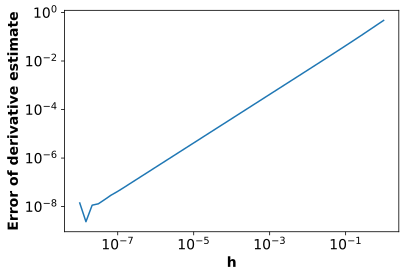

In [4]:
f = lambda x: np.sin(x)
dfdx_estimate = lambda h: (f(x0 + h) - f(x0)) / h
dfdx_true = np.cos(x0)
abs_error = lambda h: np.abs(dfdx_estimate(h) - dfdx_true)

h = 10 ** (np.linspace(-8, 0))
plt.loglog(h, abs_error(h))
plt.xlabel("h")
plt.ylabel("Error of derivative estimate");

The above plot says that the error between our estimate and the true derivative grows as $h$ gets bigger. Makes sense, right? But the plot thickens when we look at very small values of $h$...

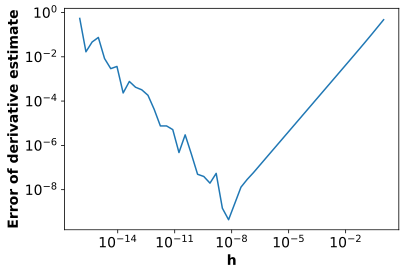

In [5]:
h = 10 ** (np.linspace(-16, 0))
plt.loglog(h, abs_error(h))
plt.xlabel("h")
plt.ylabel("Error of derivative estimate");

Wait... what?

When $h\ll 1$ we have that $\left| f(x+h)-f(x) \right| \ll 1$. This leads to _roundoff errors_. Is it underflow?

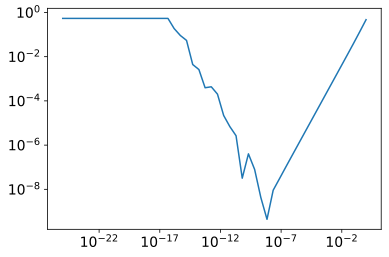

In [6]:
h = 10 ** (np.linspace(-25, 0))
plt.loglog(h, abs_error(h));

Well that flat part is underflow (estimate of the derivative is exactly zero). But what's up with the part in between, from $h=10^{-16}$ to $10^{-7}$?

The problem is regular old roundoff error (go back to [Lecture 1](lecture1_floating-point.ipynb) if you've forgottn what this is). Roughly speaking, the magnitude of these roundoff errors is independent of $h$ (e.g. when computing $f(x)$ it has nothing to do with $h$), and so the $h$ in the denominator causes $\frac{1}{h}$-like behavior. We can test this with a line, using our friend $10^{-16}$ from [Lecture 1](lecture1_floating-point.ipynb).

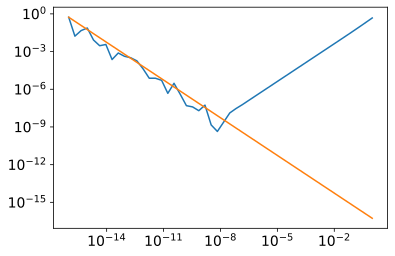

In [7]:
h = 10 ** (np.linspace(-16, 0))
plt.loglog(h, abs_error(h))
plt.loglog(h, 1e-16 * dfdx_true / h);

We've seen a bunch of plots, but what have we actually learned? Well:

- the _numerical approximation_ to the derivative initially increases as $h$ gets smaller (this effect is linear in $h$)
- however, when $h$ is too small then roundoff error kicks in and the error starts to increase (this effect is linear in $1/h$)

What you really need to know: picking $h$ is tricky: it can't be too big or too small.

### Gradients

So, what about gradients?

$$\nabla f(x) = \begin{bmatrix} \frac{\partial f}{\partial x_1} \\ \frac{\partial f}{\partial x_2} \\ \vdots \\ \frac{\partial f}{\partial x_d} \end{bmatrix}$$ 

Well, we can approximate each partial derivative as:

$$\frac{\partial f(x)}{\partial x_1} \approx \frac{f(x+h e_1)-f(x)}{h}$$ 

where $e_1 = \begin{bmatrix}1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}$. 

In general, $$\frac{\partial f(x)}{\partial x_j} \approx \frac{f(x+h e_j)-f(x)}{h}$$ 

where $e_j$ is $1$ at position $j$ and zero elsewhere.

Put another way (if this helps),

$$\frac{\partial f(x)}{\partial x_1} \approx \frac{f\left(\begin{bmatrix}x_1 + h \\ x_2 \\ x_3 \\ \vdots \\ x_d \end{bmatrix} \right)-f(x)}{h}$$ 

$$\frac{\partial f(x)}{\partial x_2} \approx \frac{f\left(\begin{bmatrix}x_1 \\ x_2 + h \\ x_3 \\ \vdots \\ x_d \end{bmatrix} \right)-f(x)}{h}$$ 

And so on and so forth.

### Cost of Estimating a Gradient

As you can see above, estimating a gradient requires $d+1$ function evaluations. That can be expensive - perhaps $d$ is $1000$ or $10000$. If you can compute the gradient symbolically, that is much better.

### (Optional) Other Finite Difference Formulas

There are better finite differences formulas than the one we are using, such as the centered difference formula:

$$\frac{df(x)}{dx} \approx \frac{f(x+h)-f(x-h)}{2h}$$

In this case the error goes down as $h^2$, which is great, but most of the benefits come in applications that don't concern us here (e.g., solving differential equations). However, in $d$ dimensions, this requires $2d$ evaluations of the function instead of $d+1$, because with the forward difference formula (the original one above) we reuse the point $f(x)$ for all the partial derivatives. Really, which formula you use depends on what you're doing.

If you're really bored, you can also check out the [complex step method](https://timvieira.github.io/blog/post/2014/08/07/complex-step-derivative/).

### Summary

If we can't figure out the derivative of a function, but have code that computes the function, we can _approximate_ the derivative using finite differences. This works pretty well but there are some pitfalls. In particular you need to choose $h$ carefully and it costs $O(d)$ function evaluations to estimate a gradient. It seems better to actually know the derivative if possible, because the computations will be faster and more accurate.

## Automatic Differentiation


Automatic differentiation (AD) is another way to take the derivative given some code that computes $f$. It is advertised as the "best of both worlds" between symbolic and numerical differentiation:
  - Pro: takes the code as input, not math.
  - Pro: does not have the problem of choosing $h$, or the extra $O(d)$ cost.
  - Con: some AD software packages have limitations, hurt code readability.
  - Con: large space complexity.
  
There are two main types of AD, _forward mode_ and _reverse mode_ AD. We'll be discussing reverse mode here. Basically, AD keeps track of the gradient of primitive operations and uses the chain rule to link them together. We'll use a package called `AutoGrad` to demo AD.

Demonstration 1: $\sin(x)$

In [8]:
anp.cos(1.0)

0.5403023058681398

In [9]:
grad(anp.sin)(1.0)

0.5403023058681398

What happened above is that AutoGrad's `grad` takes in a Python function, and returns another Python function that computes the gradient.

Some more examples:

In [10]:
x = anp.random.rand(4)

def foo(x):
    return anp.sum(x)

def foo_grad(x):
    return anp.ones(len(x)) ## SOLUTION

foo_grad(x)

array([1., 1., 1., 1.])

In [11]:
foo_grad_AD = grad(foo)
foo_grad_AD(x)

array([1., 1., 1., 1.])

In [12]:
def pin(x):
    return anp.sin(x[1])

def pin_grad(x):
    grad = anp.zeros(len(x)) ## SOLUTION
    grad[1] = anp.cos(x[1])
    return grad

pin_grad(x)

array([0.       , 0.8388448, 0.       , 0.       ])

In [13]:
pin_grad_AD = grad(pin)
pin_grad_AD(x)

array([0.       , 0.8388448, 0.       , 0.       ])

As you can see above, Autograd knows how to deal with things like `np.sum`, `np.abs`, subtraction, addition, etc. But let's make sure it wasn't cheating and just doing numerical differentiation!

In [14]:
def pin(x):
    print("Evaluated function!") # let us know what it's doing
    return anp.sin(x[1])

def pin_grad(x):
    grad = anp.zeros(len(x)) ## SOLUTION
    grad[1] = anp.cos(x[1])
    return grad

If it were doing numerical differentiation, it would need to evaluation the function $d+1$ times (5 times in this case), like this:

In [15]:
scipy.optimize.approx_fprime(x, pin, 1e-6) # do numerical differentiation

Evaluated function!
Evaluated function!
Evaluated function!
Evaluated function!
Evaluated function!


array([0.        , 0.83884453, 0.        , 0.        ])

In [16]:
pin_grad_AD = grad(pin) # automatic differentiation
pin_grad_AD(x)

Evaluated function!


array([0.       , 0.8388448, 0.       , 0.       ])

Looks like it's not doing numerical differentiation! Bam!

In [17]:
def baz(x):
    result = 0
    for i in range(len(x)):
        result = result + x[i]**i
    return result

def baz_grad(x):
    result = [0] ## SOLUTION
    for i in range(1,len(x)):
        result.append(i*x[i]**(i-1))
    return result

baz_grad(x)

[0, 1.0, 0.22176843559103543, 1.5829762293698537]

In [18]:
baz_grad_AD = grad(baz) # differentiate through `for` loops!
baz_grad_AD(x)

array([0.        , 1.        , 0.22176844, 1.58297623])

In [19]:
def bar(x):
    if anp.abs(x[1]) > 2:
        return 0
    else:
        return -(x[0] * x[0] + 1) * anp.cos(x[1] - 1)


def bar_grad(x):
    if anp.abs(x[1]) > 2:  ## SOLUTION
        return anp.zeros(len(x))
    else:
        result = 0 * x
        result[0] = -2 * x[0] * anp.cos(x[1] - 1)
        result[1] = (x[0] * x[0] + 1) * anp.sin(x[1] - 1)
        return result


bar_grad(x)

array([-0.95277637, -0.52425614,  0.        ,  0.        ])

In [20]:
bar_grad_AD = grad(bar) # differentiate through `if` statements!
bar_grad_AD(x)

array([-0.95277637, -0.52425614,  0.        ,  0.        ])

As an additional demo, let's try robust regression with the Huber loss (whose derivative I don't really feel like dealing with):

In [21]:
d = 10
n = 1000

# generate random data
X = anp.random.randn(n, d)
w_true = anp.random.randn(d)
y = X @ w_true
# add random outliers
Noutliers = 50
y[:Noutliers] += 100 * anp.random.randn(Noutliers)
w_true

array([-0.97369251, -2.31538039, -0.70716912,  0.84031742, -2.23766131,
       -0.23711665, -1.00731654,  0.07554957, -0.58959108,  0.46803134])

In [22]:
from sklearn.linear_model import HuberRegressor

hr = HuberRegressor(fit_intercept=False, alpha=0)
hr.fit(X, y)
hr.coef_

array([-0.9736925 , -2.31538045, -0.7071691 ,  0.84031747, -2.23766131,
       -0.23711668, -1.00731657,  0.07554957, -0.58959108,  0.46803136])

In [23]:
huber = lambda z: 0.5 * z ** 2 * (anp.abs(z) <= 1) + (anp.abs(z) - 0.5) * (anp.abs(z) > 1)
f = lambda w: anp.sum(huber(X @ w - y))

Okay here we go:

In [24]:
df_dw = grad(f) # differentiate through matrix multiplications, etc.

In [25]:
w = np.zeros(d)

alpha = 0.001
while anp.linalg.norm(df_dw(w)) > 0.0001:
    w -= alpha * df_dw(w)

w

array([-0.96555241, -2.32608123, -0.71405059,  0.84137761, -2.226602  ,
       -0.24343648, -1.00125349,  0.08771633, -0.59001858,  0.46743015])

Nice! (They are not exactly the same because of `epsilon` hyperparameter in `HuberRegressor`.)


### Do I Never Need to Take a Derivative Again?

Hopefully not? There are production-grade automatic differentiation systems, like those used in TensorFlow or PyTorch so you may never have to worry about taking a derivative ever again.